a metric to calculate all possible time gaps between two filters


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn

import healpy as hp
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.db as db


In [2]:
# connect to opsim database
opsdb_baseline = db.OpsimDatabase('opsdb/baseline2018a.db')
opsdb_pontus = db.OpsimDatabase('opsdb/pontus_2573.db')
opsdb_baseline10yrs = db.OpsimDatabase('opsdb/baseline_2snap_v1.3_10yrs.db')

# output directory
outDir = 'outdir'
resultsDb = db.ResultsDb(outDir=outDir)

In [ ]:
class timeGapsMetric(metrics.BaseMetric):
    """
    returns all time gaps between two filters
    """

    def __init__(self, colname=['observationStartMJD', 'filter', 'fiveSigmaDepth'], 
                 filename='dT.pkl', fltpair=['y','i'],
                 dataout=True, **kwargs):
        self.colname = colname
        self.filename = filename
        self.fltpair = fltpair
        self.dataout = dataout
        
        #if os.path.isfile(filename):
            # rm old file
        #    os.system("rm filename")
        
        if self.dataout:
            super().__init__(col=self.colname, metricDtype='object', **kwargs)
        else:
            super().__init__(col=self.colname, metricDtype='float', **kwargs)
        
    def dT(self, dataSlice, f0='i', f1='r'):
        ''' return an array that contains all time gaps between two filters'''
        idx0 = dataSlice['filter'] == f0
        idx1 = dataSlice['filter'] == f1
        
        timeCol0 = dataSlice['observationStartMJD'][idx0]
        timeCol1 = dataSlice['observationStartMJD'][idx1]

        timeCol0 = timeCol0.reshape((len(timeCol0), 1))
        timeCol1 = timeCol1.reshape((len(timeCol1), 1))

        diffmat = np.abs( np.subtract(timeCol0, timeCol1.T) )

        return diffmat.flatten()


    def load_from_pkl(self, filename="test_pkl.pkl"):
        '''load dataframe from pickle'''
        if os.path.isfile(filename):
            df = pd.read_pickle(filename)
        else:
            df = pd.DataFrame()
            df.to_pickle(filename)
        return df
    
    def save_to_file(self, dic, filename="test_pkl.pkl"):
        '''save dict item to pickle file'''
        
        df = self.load_from_pkl(filename)

        df = df.append(pd.DataFrame(dic), ignore_index=True)

        df.to_pickle(filename)
    
    def run(self, dataSlice, slicePoint=None):
        # sort dataSlice
        flt = ['u', 'g', 'r', 'i', 'z', 'y']
        fdict = {'u':0, 'g':1, 'r':2, 'i':3, 'z':4, 'y':5}

        dataSlice.sort(order='observationStartMJD')

        dT = self.dT(dataSlice, f0=self.fltpair[0], f1=self.fltpair[1])
        #print(type(dataSlice['fieldRA']), dataSlice['fieldDec'])
        #dT_list = []
        #for i in range(len(dataSlice['fieldRA'])):
        #   dT_list.append(dT)
        
        dic = {'ra':np.mean(dataSlice['fieldRA']), 'dec':np.mean(dataSlice['fieldDec']), 'dT': [dT]}
        # print(dic)
        # save to file
        self.save_to_file(dic, self.filename)
        
        # return dT
        if self.dataout:
            result = dT
            return result
        else:
            f0 = self.fltpair[0]
            f1 = self.fltpair[1]
            result = np.min(dT) if len(dT)!=0 else np.inf
            return float(result)
      

**run for one filter pair**

In [ ]:
# run the metric, check same filename in folder
metric = timeGapsMetric(colname=['observationStartMJD', 'filter', 'fiveSigmaDepth'], 
                          filename='dT_ri.pkl', fltpair=['r','i'], dataout=False)
slicer = slicers.HealpixSlicer(nside=16)

sqlconstraint = 'night<400'
metricSky = metricBundles.MetricBundle(metric,slicer,sqlconstraint)

group = metricBundles.MetricBundleGroup({'metricSky':metricSky}, opsdb_pontus, outDir=outDir, resultsDb=resultsDb)
group.runAll()

**run for all filter pair**

In [ ]:
# create a metric dict and run for all filter pairs

slicer = slicers.HealpixSlicer(nside=16)

sqlconstraint = 'night<400'

# create an dict to run metric for all pairs
metricSkyDict = {}
flt = ['u', 'g', 'r', 'i', 'z', 'y']
for i, f0 in enumerate(flt):
    for f1 in flt[i:]:
        filename = 'dT_{}{}_pontus.pkl'.format(f0, f1)
        fltpair = [f0, f1]
        metric = timeGapsMetric(colname=['observationStartMJD', 'filter', 'fiveSigmaDepth'], 
                          filename=filename, fltpair=fltpair, dataout=False)
        
        metricSky = metricBundles.MetricBundle(metric,slicer,sqlconstraint)
        metricSkyname = 'metricSky_{}{}'.format(f0, f1)
        metricSkyDict[metricSkyname] = metricSky

In [ ]:
group = metricBundles.MetricBundleGroup(metricSkyDict, opsdb_pontus, outDir=outDir, resultsDb=resultsDb)
group.runAll()


### baseline 10yrs

In [92]:
# load the data
opsdb = 'bsline10yrs'
df_dict = {}
for i, f0 in enumerate(flt):
    for f1 in flt[i:]:
        filename = 'dT_{}{}_{}.pkl'.format(f0, f1, opsdb)
        df = pd.read_pickle(filename)
        df_dict[filename] = df


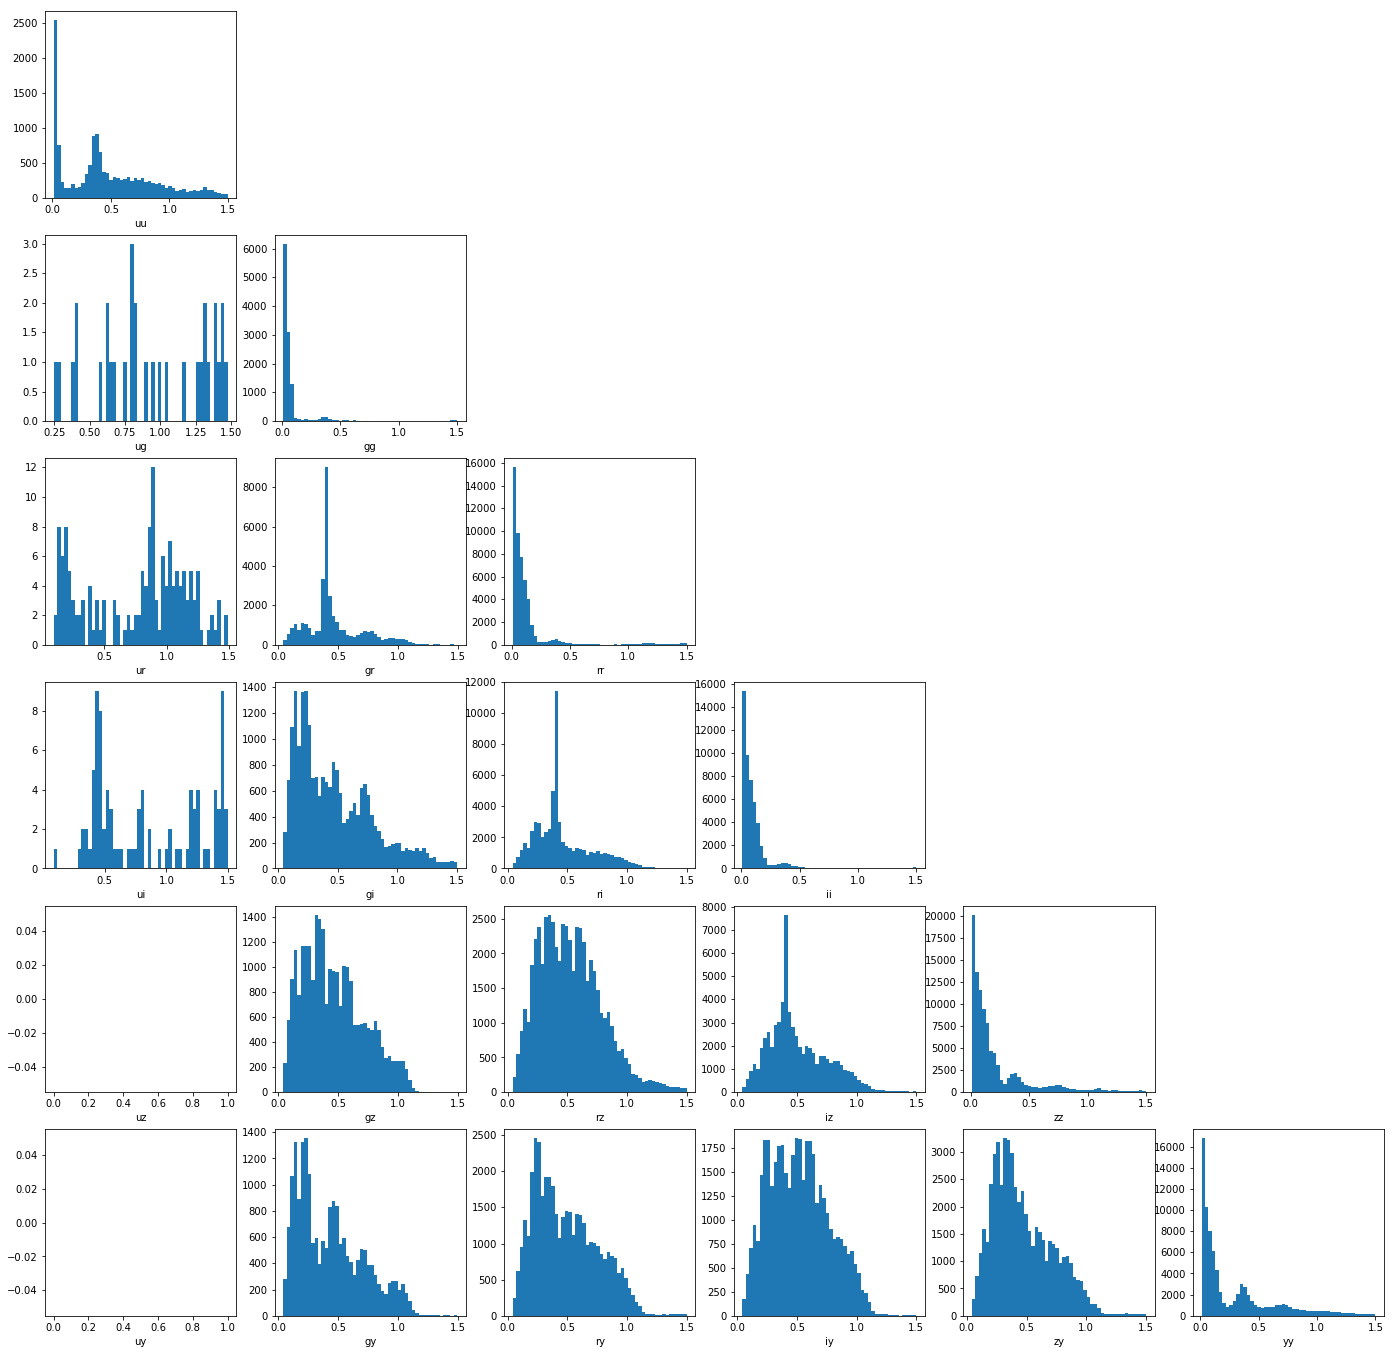

In [7]:
fig, axs = plt.subplots(6, 6, figsize=(24, 24)); # 6 axes on a 2x3 grid

opsdb = 'bsline10yrs'
flt = ['u', 'g', 'r', 'i', 'z', 'y']
fdict = {'u':0, 'g':1, 'r':2, 'i':3, 'z':4, 'y':5}
tlim = 1.5 # in hours
for i, f0 in enumerate(flt):
    for f1 in flt[i:]:
        filename = 'dT_{}{}_{}.pkl'.format(f0, f1, opsdb)
        #df = pd.read_pickle(filename)
        df = df_dict[filename]
        dT = np.concatenate(df.dT)
        dT = dT[dT!=0]
        #axs[fdict[f0], fdict[f1]].hist(dT[dT<1/24],bins=100); 
        if f0==f1:
            axs[fdict[f0], fdict[f1]].hist(dT[dT<tlim/24]*24,bins=50); 
            axs[fdict[f0], fdict[f1]].set_xlabel(f0+f1)
        else:
            axs[fdict[f0], fdict[f1]].axis('off')
            axs[fdict[f1], fdict[f0]].hist(dT[dT<tlim/24]*24,bins=50);        
            axs[fdict[f1], fdict[f0]].set_xlabel(f0+f1)


In [42]:
def plot_mwd(ax, RA, Dec, c, org=0, title='Mollweide projection', projection='mollweide'):
    ''' RA, Dec are arrays of the same length.
    RA takes values in [0,360), Dec in [-90,90],
    which represent angles in degrees.
    org is the origin of the plot, 0 or a multiple of 30 degrees in [0,360).
    title is the title of the figure.
    projection is the kind of projection: 'mollweide', 'aitoff', 'hammer', 'lambert'
    
    Examples:
    >>> plot_mwd(df['ra'], df['dec'], df['metricValues'])
    '''
    x = np.remainder(RA+360-org,360) # shift RA values
    ind = x>180
    x[ind] -=360    # scale conversion to [-180, 180]
    x=-x    # reverse the scale: East to the left
    tick_labels = np.array([150, 120, 90, 60, 30, 0, 330, 300, 270, 240, 210])
    tick_labels = np.remainder(tick_labels+360+org,360)
    # fig = plt.figure(figsize=(10, 5))
    # ax = fig.add_subplot(111, projection=projection, facecolor ='LightCyan')
    # ax = fig.add_subplot(111, projection=projection, facecolor ='honeydew')
    sc = ax.scatter(np.radians(x), np.radians(Dec), c=c, marker='o')  # convert degrees to radians
    # ax.set_xticklabels(tick_labels)     # we add the scale on the x axis
    ax.set_title(title)
    ax.title.set_fontsize(15)
    ax.set_xlabel("RA")
    ax.xaxis.label.set_fontsize(12)
    ax.set_ylabel("Dec")
    ax.yaxis.label.set_fontsize(12)
    ax.grid(True)
    plt.colorbar(sc, ax=ax, orientation="horizontal")
    

In [81]:
def get_nvisits(dT, tlim=1.5):
    dT = dT[ (dT>0) & (dT<=tlim/24) ]
    if 0<len(dT)<100:
        return len(dT)
    else:
        return np.inf

In [82]:
def get_tmin(dT, tlim=1.5):
    dT = dT[ (dT>0) & (dT<=tlim/24) ]
    if len(dT)!=0:
        return np.min(dT)*24
    else:
        return np.inf

/home/docmaf/stack/python/miniconda3-4.3.21/lib/python3.6/site-packages/matplotlib/projections/geo.py:493: RuntimeWarning: invalid value encountered in arcsin
  theta = np.arcsin(y / np.sqrt(2))


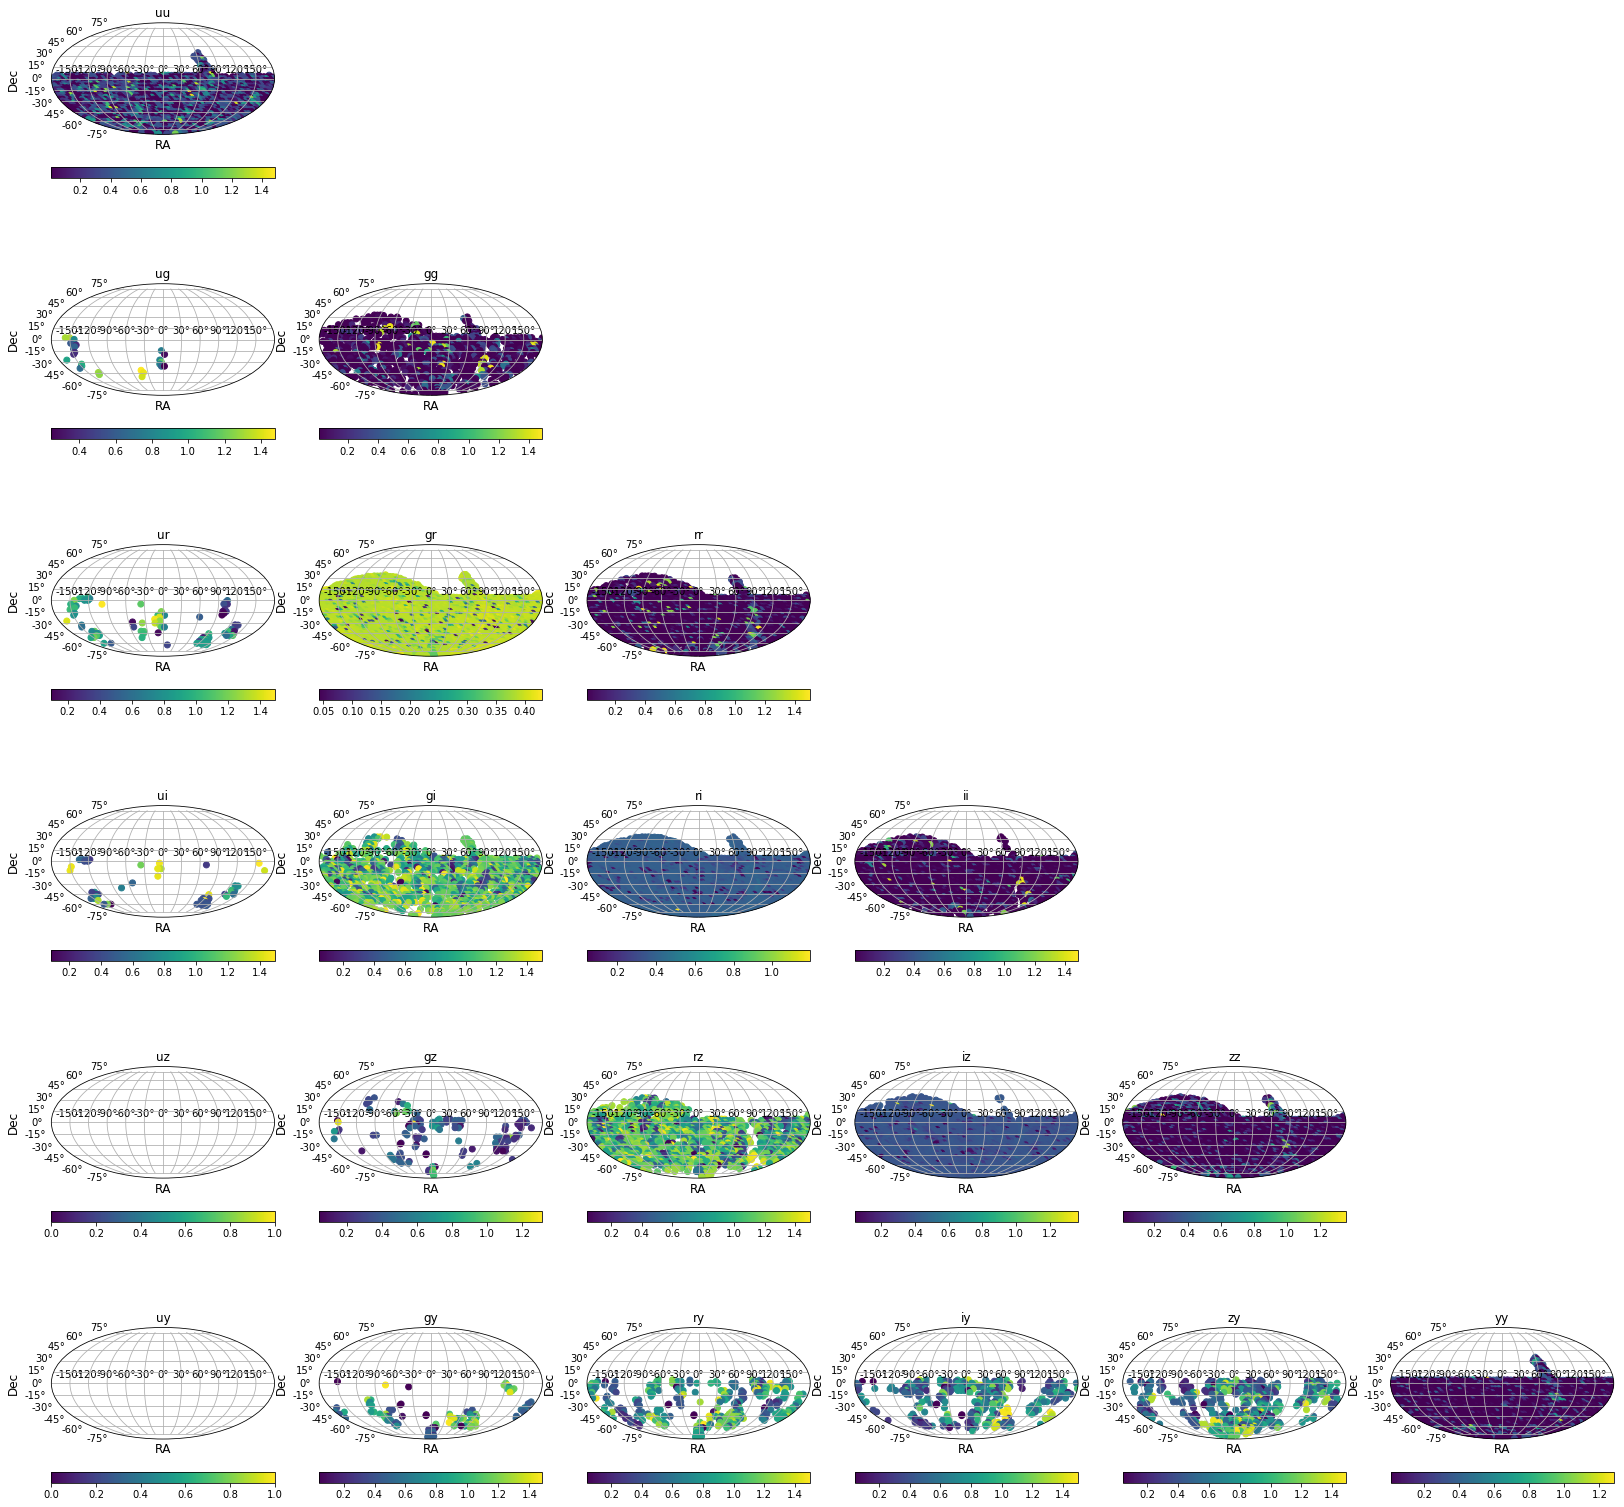

In [70]:
# plot skymap 
opsdb = 'bsline10yrs'

fig, axs = plt.subplots(6, 6, figsize=(28, 28), 
                        subplot_kw={'projection': 'mollweide'}); # 6 axes on a 2x3 grid

for i, f0 in enumerate(flt):
    for f1 in flt[i:]:

        filename = 'dT_{}{}_{}.pkl'.format(f0, f1, opsdb)     
        df = df_dict[filename]
        
        if f0==f1:
            ax = axs[fdict[f0], fdict[f1]]
            plot_mwd(ax, df.ra.values, df.dec.values, 
                     df['dT'].apply(get_tmin, tlim=1.5).values)
            ax.set_title(f0+f1)
        else:
            axs[fdict[f0], fdict[f1]].axis('off')
            ax = axs[fdict[f1], fdict[f0]]
            plot_mwd(ax, df.ra.values, df.dec.values, 
                     df['dT'].apply(get_tmin, tlim=1.5).values)
            ax.set_title(f0+f1)


/home/docmaf/stack/python/miniconda3-4.3.21/lib/python3.6/site-packages/matplotlib/projections/geo.py:493: RuntimeWarning: invalid value encountered in arcsin
  theta = np.arcsin(y / np.sqrt(2))


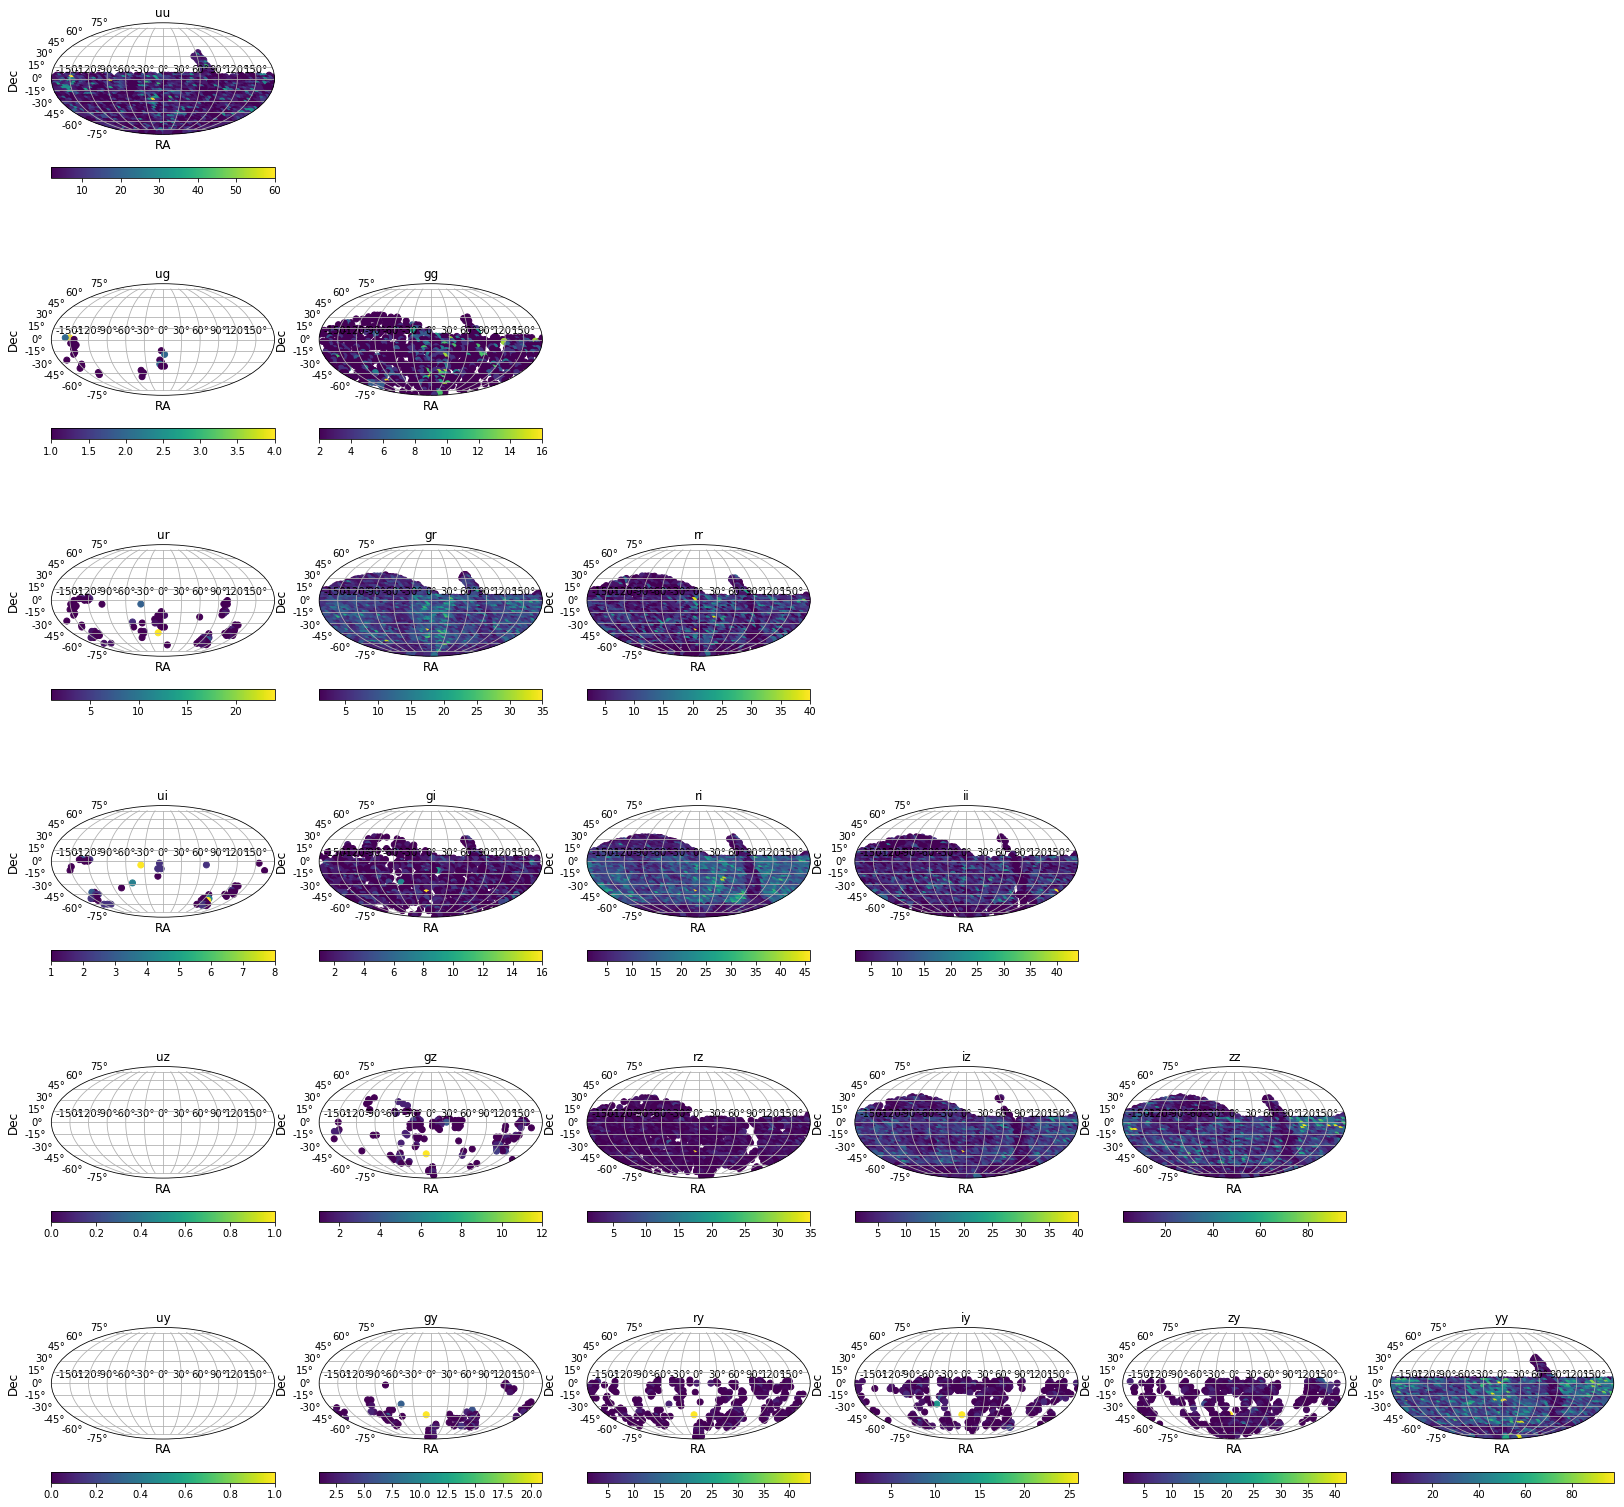

In [93]:
# plot skymap 
opsdb = 'bsline10yrs'

fig, axs = plt.subplots(6, 6, figsize=(28, 28), 
                        subplot_kw={'projection': 'mollweide'}); # 6 axes on a 2x3 grid

for i, f0 in enumerate(flt):
    for f1 in flt[i:]:

        filename = 'dT_{}{}_{}.pkl'.format(f0, f1, opsdb)     
        df = df_dict[filename]
        # print(filename)
        if f0==f1:
            ax = axs[fdict[f0], fdict[f1]]
            plot_mwd(ax, df.ra.values, df.dec.values, 
                     df['dT'].apply(get_nvisits, tlim=1.5).values)
            ax.set_title(f0+f1)
        else:
            axs[fdict[f0], fdict[f1]].axis('off')
            ax = axs[fdict[f1], fdict[f0]]
            plot_mwd(ax, df.ra.values, df.dec.values, 
                     df['dT'].apply(get_nvisits, tlim=1.5).values)
            ax.set_title(f0+f1)


### pontus

In [84]:
# load the data
opsdb = 'pontus'
df_dict = {}
for i, f0 in enumerate(flt):
    for f1 in flt[i:]:
        filename = 'dT_{}{}_{}.pkl'.format(f0, f1, opsdb)
        df = pd.read_pickle(filename)
        df_dict[filename] = df

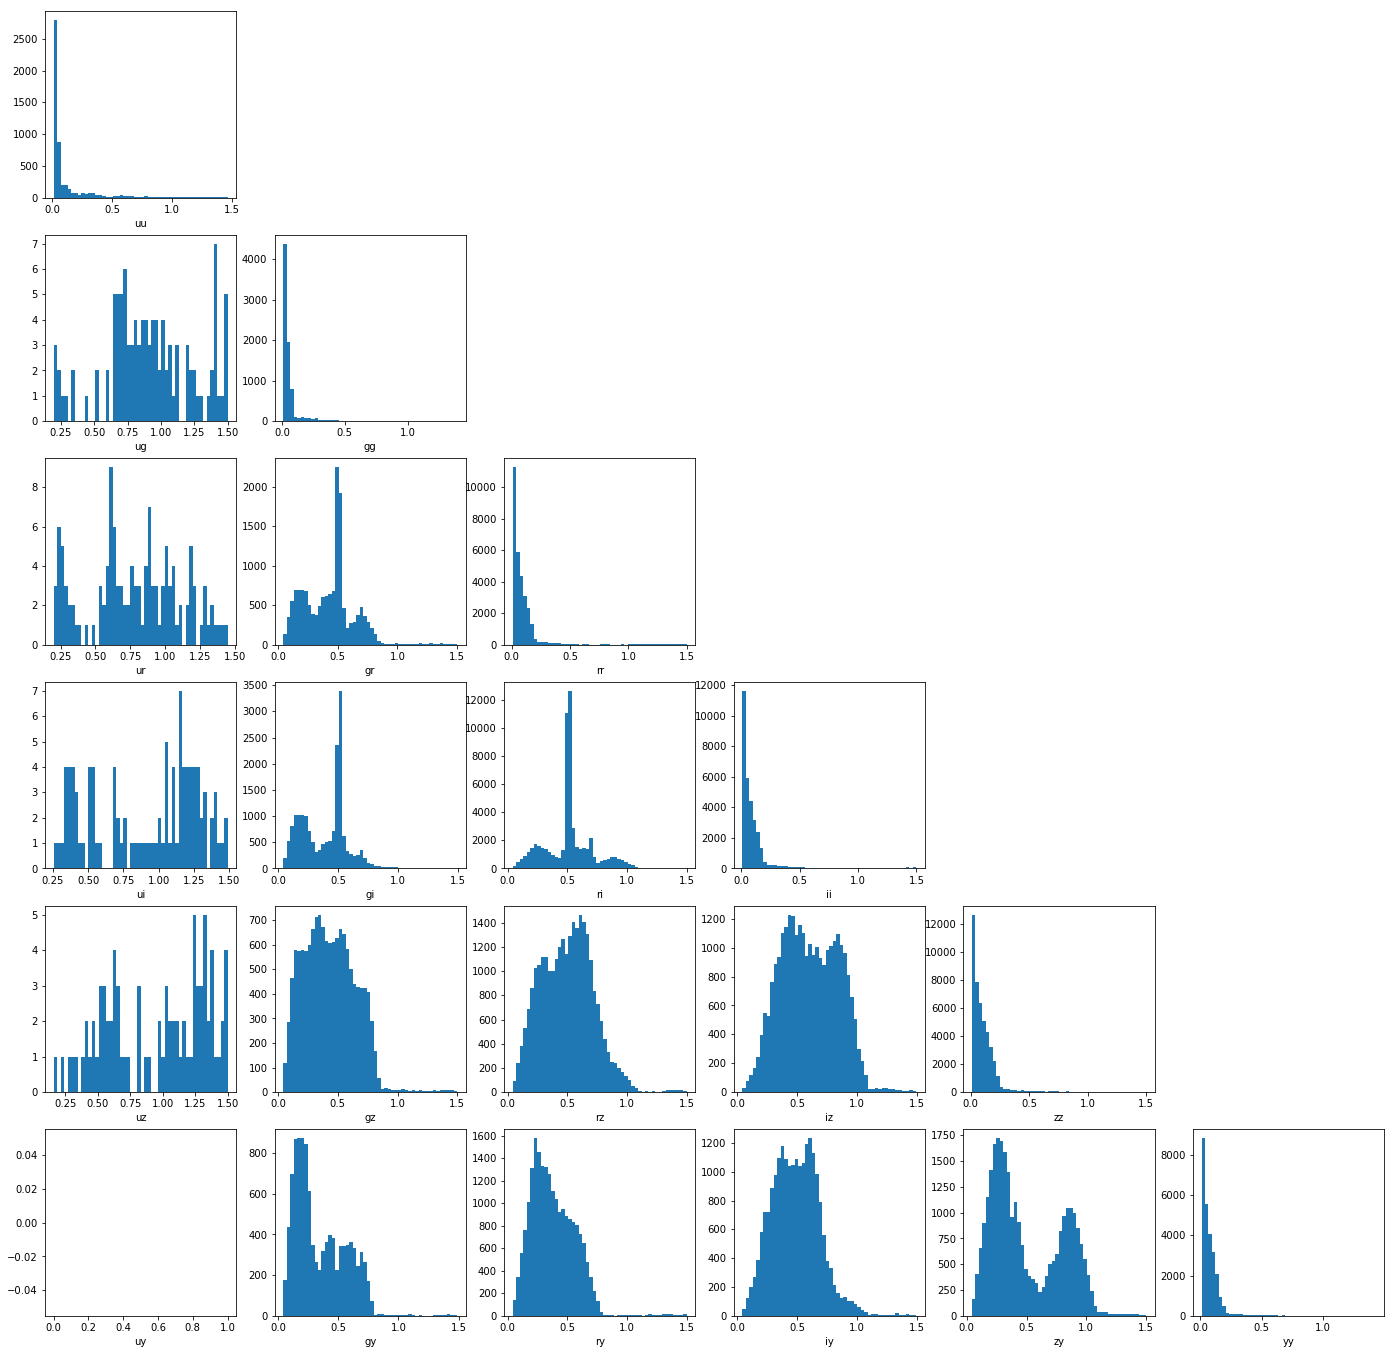

In [88]:
# plot histogram

fig, axs = plt.subplots(6, 6, figsize=(24, 24)); # 6 axes on a 2x3 grid

opsdb = 'pontus'
flt = ['u', 'g', 'r', 'i', 'z', 'y']
fdict = {'u':0, 'g':1, 'r':2, 'i':3, 'z':4, 'y':5}
tlim = 1.5 # in hours
for i, f0 in enumerate(flt):
    for f1 in flt[i:]:
        filename = 'dT_{}{}_{}.pkl'.format(f0, f1, opsdb)
        #df = pd.read_pickle(filename)
        df = df_dict[filename]
        dT = np.concatenate(df.dT)
        dT = dT[dT!=0]
        #axs[fdict[f0], fdict[f1]].hist(dT[dT<1/24],bins=100); 
        if f0==f1:
            axs[fdict[f0], fdict[f1]].hist(dT[dT<tlim/24]*24,bins=50); 
            axs[fdict[f0], fdict[f1]].set_xlabel(f0+f1)
        else:
            axs[fdict[f0], fdict[f1]].axis('off')
            axs[fdict[f1], fdict[f0]].hist(dT[dT<tlim/24]*24,bins=50);        
            axs[fdict[f1], fdict[f0]].set_xlabel(f0+f1)

/home/docmaf/stack/python/miniconda3-4.3.21/lib/python3.6/site-packages/matplotlib/projections/geo.py:493: RuntimeWarning: invalid value encountered in arcsin
  theta = np.arcsin(y / np.sqrt(2))


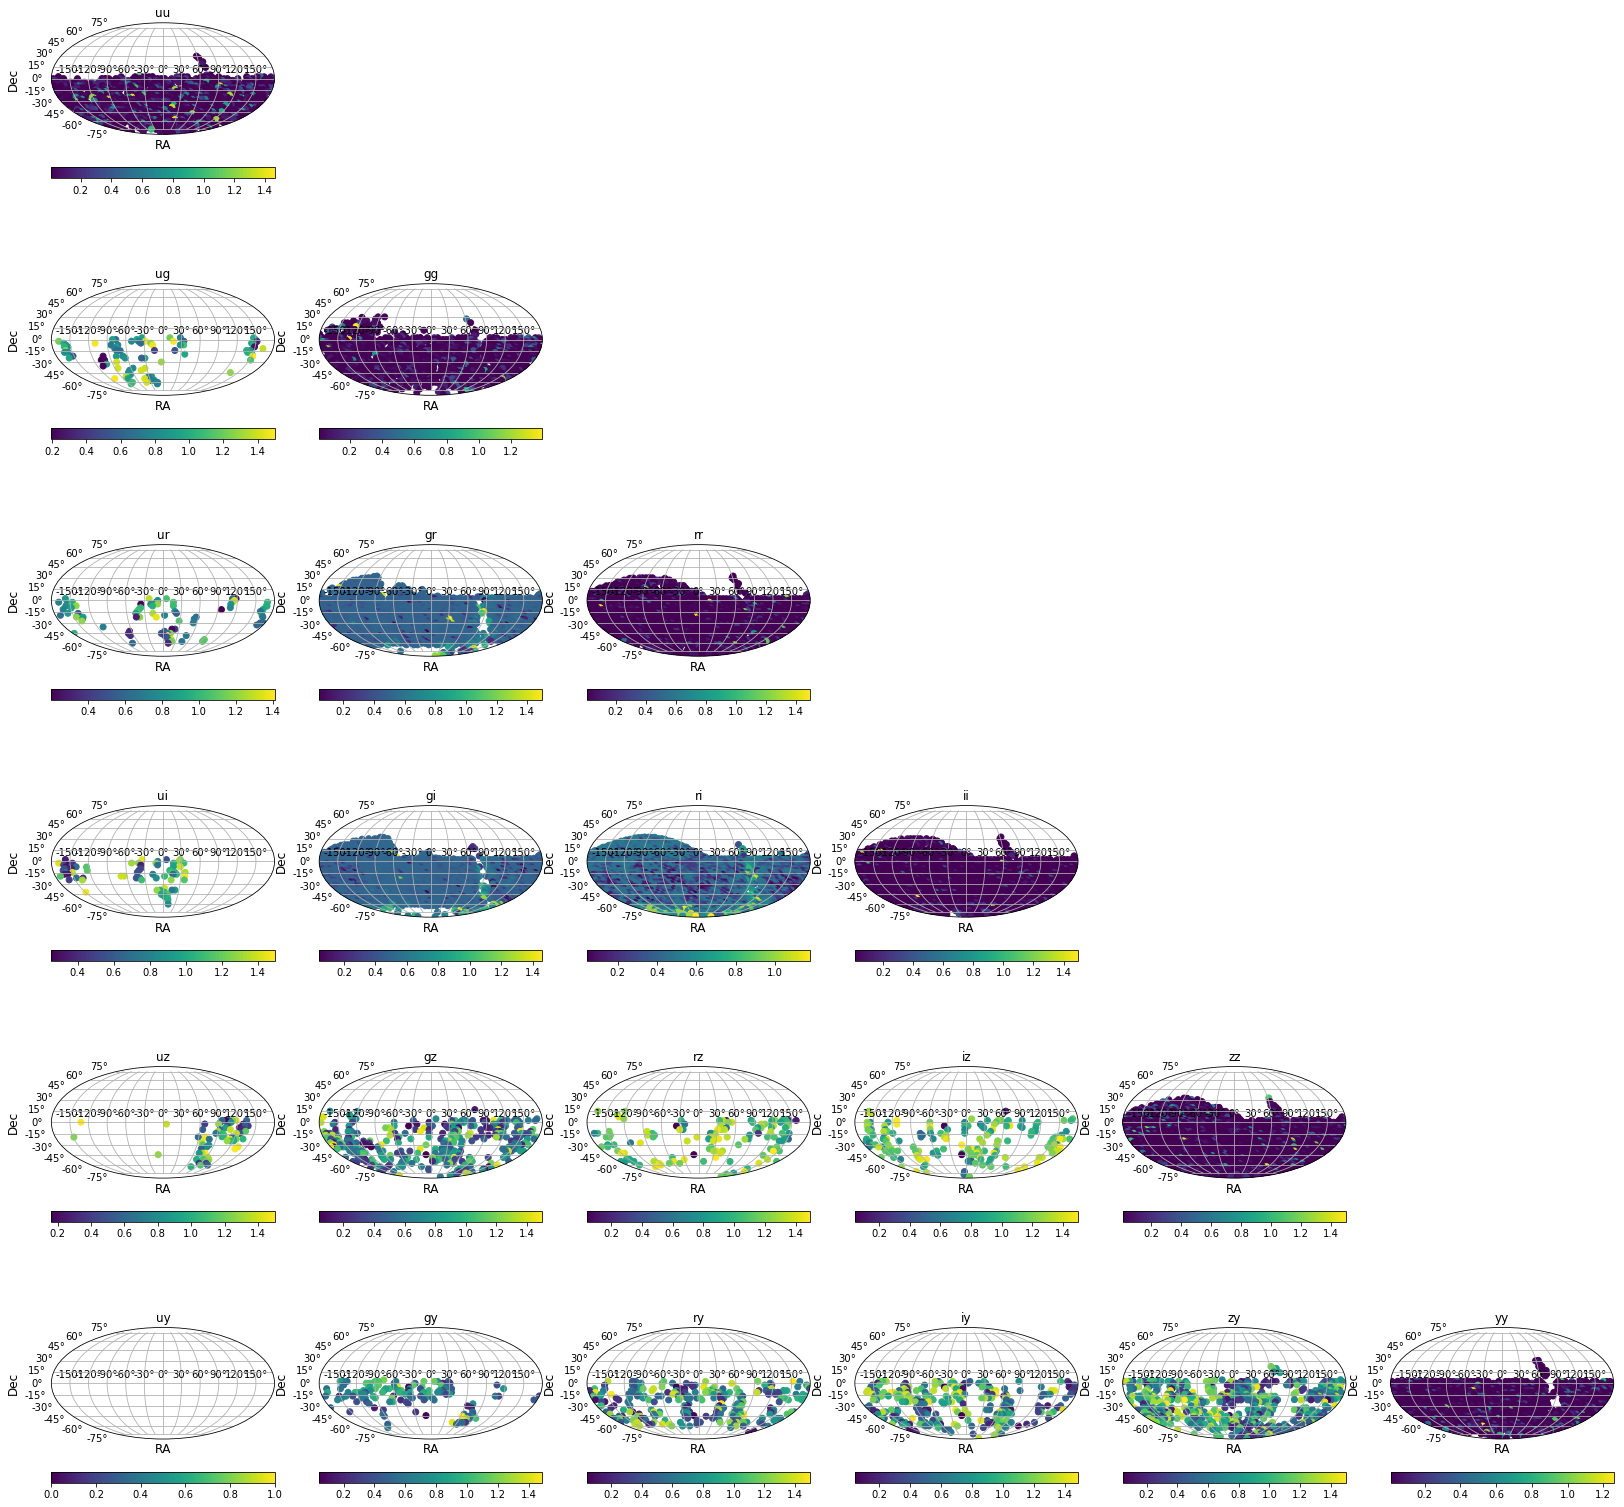

In [89]:
# plot skymap tmin
opsdb = 'pontus'

fig, axs = plt.subplots(6, 6, figsize=(28, 28), 
                        subplot_kw={'projection': 'mollweide'}); # 6 axes on a 2x3 grid

for i, f0 in enumerate(flt):
    for f1 in flt[i:]:

        filename = 'dT_{}{}_{}.pkl'.format(f0, f1, opsdb)     
        df = df_dict[filename]
        
        if f0==f1:
            ax = axs[fdict[f0], fdict[f1]]
            plot_mwd(ax, df.ra.values, df.dec.values, 
                     df['dT'].apply(get_tmin, tlim=1.5).values)
            ax.set_title(f0+f1)
        else:
            axs[fdict[f0], fdict[f1]].axis('off')
            ax = axs[fdict[f1], fdict[f0]]
            plot_mwd(ax, df.ra.values, df.dec.values, 
                     df['dT'].apply(get_tmin, tlim=1.5).values)
            ax.set_title(f0+f1)

/home/docmaf/stack/python/miniconda3-4.3.21/lib/python3.6/site-packages/matplotlib/projections/geo.py:493: RuntimeWarning: invalid value encountered in arcsin
  theta = np.arcsin(y / np.sqrt(2))


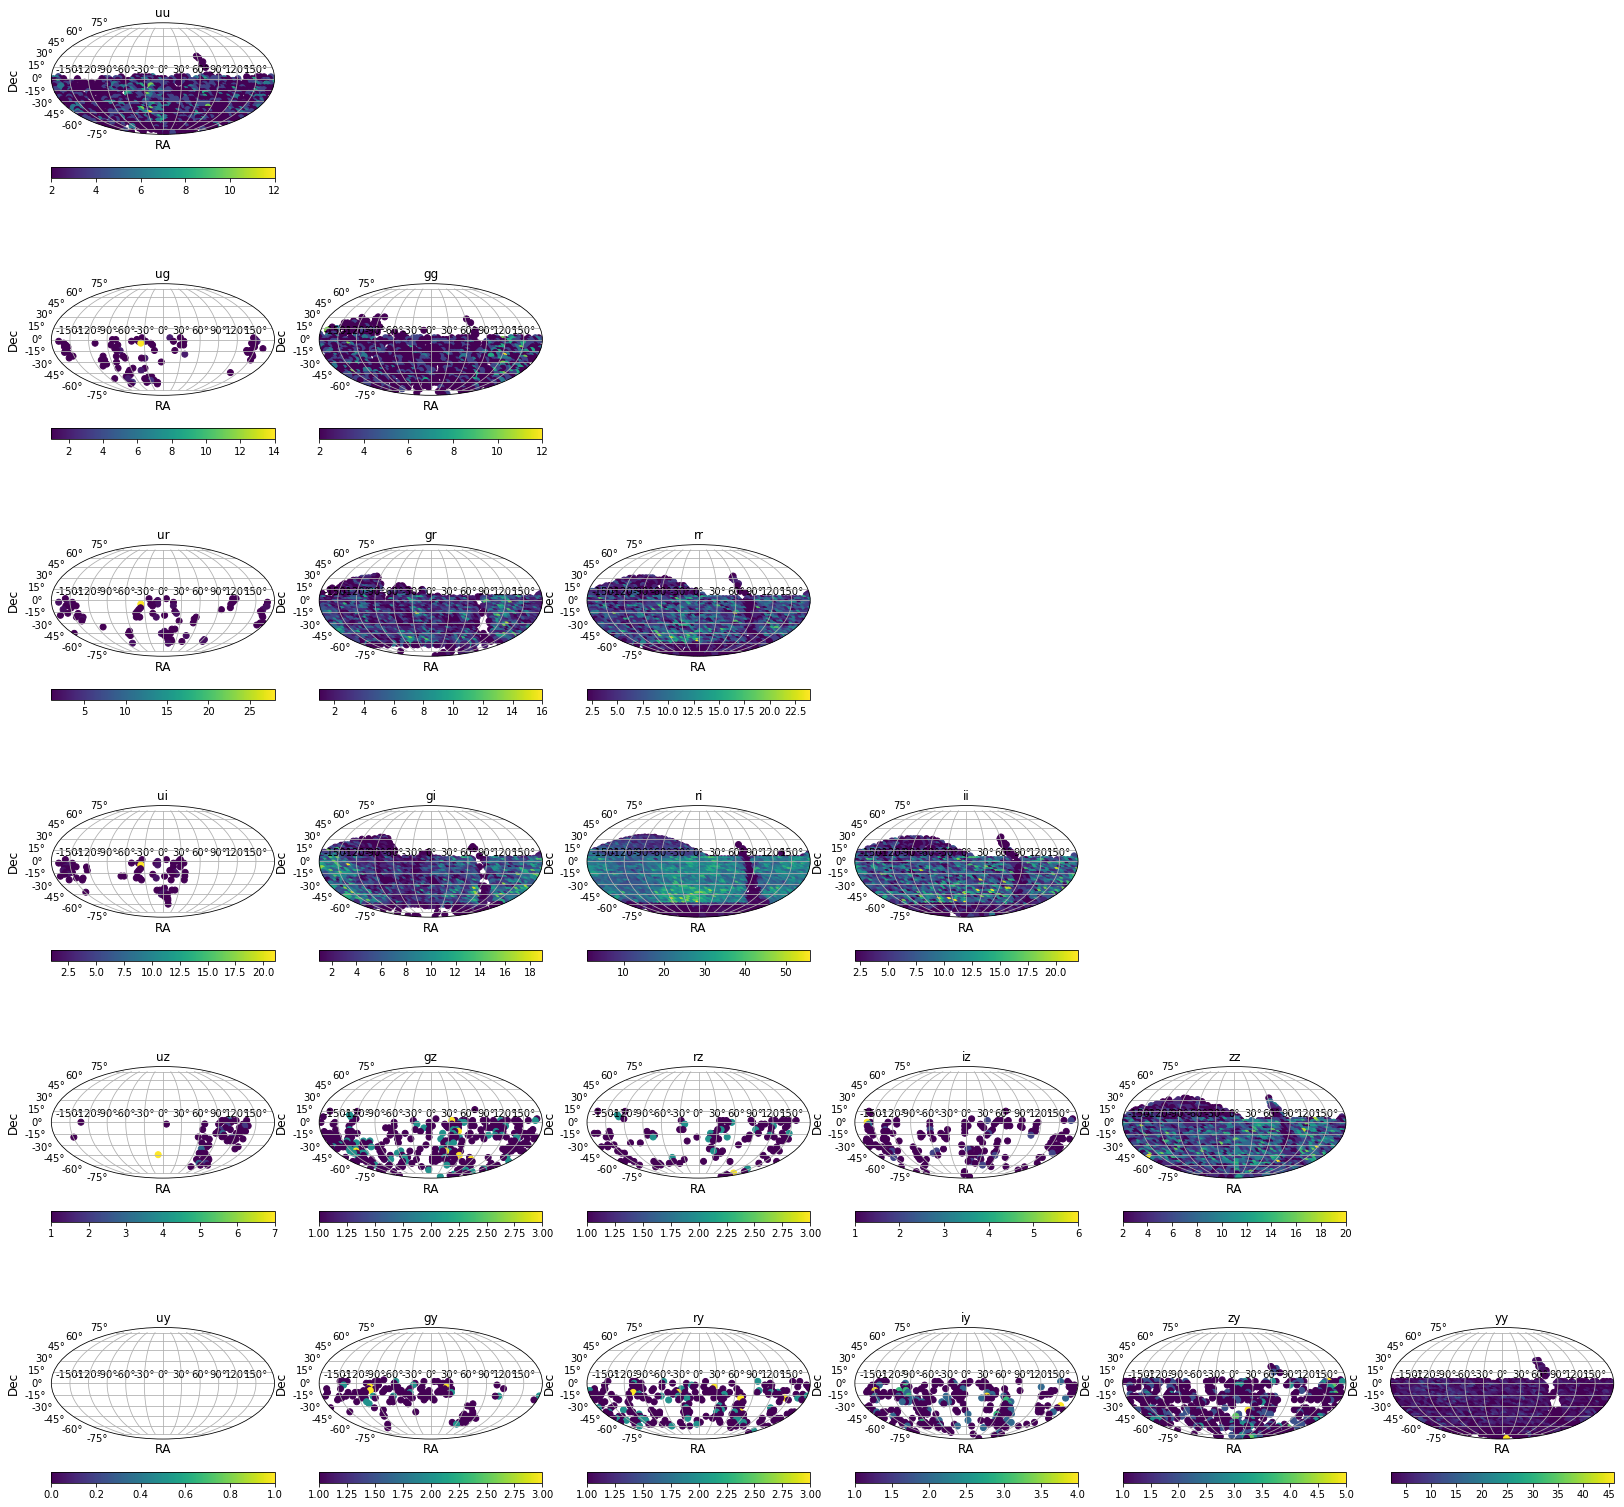

In [91]:
# plot skymap nvisits
opsdb = 'pontus'

fig, axs = plt.subplots(6, 6, figsize=(28, 28), 
                        subplot_kw={'projection': 'mollweide'}); # 6 axes on a 2x3 grid

for i, f0 in enumerate(flt):
    for f1 in flt[i:]:

        filename = 'dT_{}{}_{}.pkl'.format(f0, f1, opsdb)     
        df = df_dict[filename]
        # print(filename)
        if f0==f1:
            ax = axs[fdict[f0], fdict[f1]]
            plot_mwd(ax, df.ra.values, df.dec.values, 
                     df['dT'].apply(get_nvisits, tlim=1.5).values)
            ax.set_title(f0+f1)
        else:
            axs[fdict[f0], fdict[f1]].axis('off')
            ax = axs[fdict[f1], fdict[f0]]
            plot_mwd(ax, df.ra.values, df.dec.values, 
                     df['dT'].apply(get_nvisits, tlim=1.5).values)
            ax.set_title(f0+f1)
